# G: Explain Models

## imports

In [1]:
#for formatting
import jupyter_black

jupyter_black.load(
)

In [2]:
import copy
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
import numpy as np
import mlflow
from patsy import dmatrices  # for formula parsing

import json  # for reading signature

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

import h2o

import shap
from datetime import datetime
import os

import importlib
import re
import pickle
import dill

C:\Users\Stanley\.virtualenvs\P1-AnalyzeTrades-FUwO02Mg\lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
C:\Users\Stanley\.virtualenvs\P1-AnalyzeTrades-FUwO02Mg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## INPUT 

In [3]:
# Research tracking
runid = "d43ec62077544139b7e105bb275596d3"  # pull from previous file
# mlflow_tracking_uri = "file:D:/Stuff/OneDrive/MLflow"
# mlflow.set_tracking_uri(mlflow_tracking_uri)

forprod = True  #  typically True  after setting best params
if forprod:
    experiment_name = "P1-AnalyzeTrades_f_core"
else:
    experiment_name = "Development"

mlflow.set_experiment(experiment_name)
experiment_details = mlflow.get_experiment_by_name(experiment_name)

In [4]:
experiment_name

'P1-AnalyzeTrades_f_core'

In [5]:
## pull information

XY_df = pd.read_csv("output/e_resultcleaned.csv")
XY_df["weight"] = 1

In [6]:
## pull information from mlflow and decide model type

# TODO H2O signature missing

mlflow.end_run()
mlflow.start_run(run_id=runid)


def parse_mlflow_info(run_info):
    metrics = run_info.data.metrics
    params = run_info.data.params
    tags = run_info.data.tags
    return metrics, params, tags


metrics, params, tags = parse_mlflow_info(mlflow.get_run(runid))

mlflow.end_run()

formula_clean = params["formula"].replace("\n", "")

model_type = "general"
if "h2o" in str((tags["estimator_class"])).lower():
    model_type = "h2o"
    print(f"model type is {model_type}")

In [7]:
tags

{'estimator_class': 'sklearn.pipeline.Pipeline',
 'estimator_name': 'Pipeline',
 'mlflow.log-model.history': '[{"run_id": "d43ec62077544139b7e105bb275596d3", "artifact_path": "model", "utc_time_created": "2025-10-26 18:04:57.581630", "flavors": {"python_function": {"model_path": "model.pkl", "predict_fn": "predict", "loader_module": "mlflow.sklearn", "python_version": "3.9.13", "env": {"conda": "conda.yaml", "virtualenv": "python_env.yaml"}}, "sklearn": {"pickled_model": "model.pkl", "sklearn_version": "1.0.2", "serialization_format": "cloudpickle", "code": null}}, "model_uuid": "dc16602511034a60b029a759408e9d0e", "mlflow_version": "2.9.1", "signature": {"inputs": "[{\\"type\\": \\"double\\", \\"name\\": \\"TGT_FWD_P_E\\"}, {\\"type\\": \\"long\\", \\"name\\": \\"YEARS_TO_NORMALIZATION\\"}, {\\"type\\": \\"double\\", \\"name\\": \\"CLOSE_^VIX\\"}, {\\"type\\": \\"double\\", \\"name\\": \\"AAII_BULLISH_BULL-BEAR_SPREAD\\"}, {\\"type\\": \\"double\\", \\"name\\": \\"%_TO_STOP\\"}, {\\"ty

In [8]:
## pull model from tracking uri

# tracking_uri = mlflow.get_tracking_uri()

artifact_loc = (
    str(experiment_details.artifact_location)
    .replace("file:", "")
    .replace("file:", "")
    .replace("///", "")
)

# try pickle first, otherwise try H2O
if model_type == "h2o":
    # for h2o models
    # h2o.init()
    # mdl = h2o.import_mojo(f'{artifact_loc}/{runid}/artifacts/')
    logged_model = f"runs:/{runid}/model"
    mdl = mlflow.pyfunc.load_model(logged_model)

else:
    mdl = pickle.load(open(f"{artifact_loc}/{runid}/artifacts/model/model.pkl", "rb"))

In [9]:
## parse data

mlflow.end_run()
mlflow.start_run(run_id=runid)

if len(formula_clean) > 1:
    y, X = dmatrices(formula_clean, XY_df, return_type="dataframe")
else:
    X = XY_df.copy()
    y = XY_df[tags["target"]]


# add columns if necessary, can only add, not remove extra cols
cols_required = list(
    pd.DataFrame(
        json.loads(
            json.loads(tags["mlflow.log-model.history"])[0]["signature"]["inputs"]
        )
    )["name"]
)

add_cols = list(set(cols_required) - set(list(X.columns)))
X[add_cols] = 0

# extra columns in dataset
print(
    "extra columns in expanded dataset: "
    + str(list(set(list(X.columns)) - set(cols_required)))
)

X = X[cols_required]  # ensure X is in correct order and complete for model

mlflow.end_run()

extra columns in expanded dataset: ['AAII_1_LEVEL_0_REPORTED_BULLISH', 'CLOSE_PRICE', 'AAII_S&P_500_WEEKLY_HIGH', 'UNNAMED:_6', 'UNNAMED:_0.1', 'AAII_4_LEVEL_0_REPORTED_TOTAL', 'AAII_S&P_500_WEEKLY_CLOSE', 'COMMISSION', 'OPEN_DATE', 'GROWTH_0.5TO0.75', 'AAII_BULLISH_8-WEEK_MOV_AVG', 'TIME', 'CLOSE_^GSPC_200MA', 'WEIGHT', 'FYEPSNXT', 'ACTION', 'CLOSE_DATE', 'Unnamed: 0', 'AT_PRICE', 'PCTRETURN', 'EPS1', 'OPEN_YEAR', 'COMPANY_NAME_(IN_ALPHABETICAL_ORDER)', 'COMMENTS.1', 'TICKER', 'AAII_0_LEVEL_0_REPORTED_DATE', 'DAYSTOFYEND', 'CASH_CHG_(PNL)', 'CURRENT_PRICE', 'AAII_3_LEVEL_0_REPORTED_BEARISH', 'QTYCHG', 'FYEND', 'COMMENTS', 'UNNAMED:_8', 'EPS2', 'FILENAME', 'UNNAMED:_0', 'TARGET', 'CLOSEACT', 'UNNAMED:_0.2', 'STARTDATE', 'AAII_S&P_500_WEEKLY_LOW', 'AAII_BULLISH_AVERAGE_+ST._DEV.', 'AAII_BULLISH_BULLISH_AVERAGE', 'STOP', 'SYMBOL', 'AAII_BULLISH_AVERAGE_-_ST._DEV.', 'AAII_2_LEVEL_0_REPORTED_NEUTRAL', 'COMM_TOT', 'PNL', 'weight', 'AGE', 'CLOSE_^GSPC', 'AAII_DATE', 'OPEN_PRICE', 'QUANTITY',

In [10]:
## train test, repeat from earlier

# X_train, X_test, y_train, y_test, XY_train, XY_test = train_test_split(
#     X, y, XY_df, test_size=0.33, random_state=42)

In [11]:
## predict full dataset

if model_type == "h2o":
    y_pred = mdl.predict(X)
else:
    y_pred = mdl.predict(X)

# h2o.cluster().shutdown(prompt=False)  # if want to end earlier

In [12]:
## class


class H2ORegWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        # self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(X).as_data_frame().values
        return self.predictions.astype("float64")

In [13]:
## lightgbm pipeline


def sub_gbm(X, y_pred):
    """creates explainer based on H2O X & y frames"""
    import lightgbm as lgb
    import shap
    import h2o

    X2_df = X.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
    y2_pred_df = y_pred

    # TODO create categorical pipeline

    gbm_mdl = lgb.LGBMRegressor(n_jobs=-1)
    gbm_mdl.fit(X2_df, y2_pred_df)

    explainer = shap.Explainer(gbm_mdl.booster_)

    return explainer

## summarize overall results

date and time = 26102025_140546


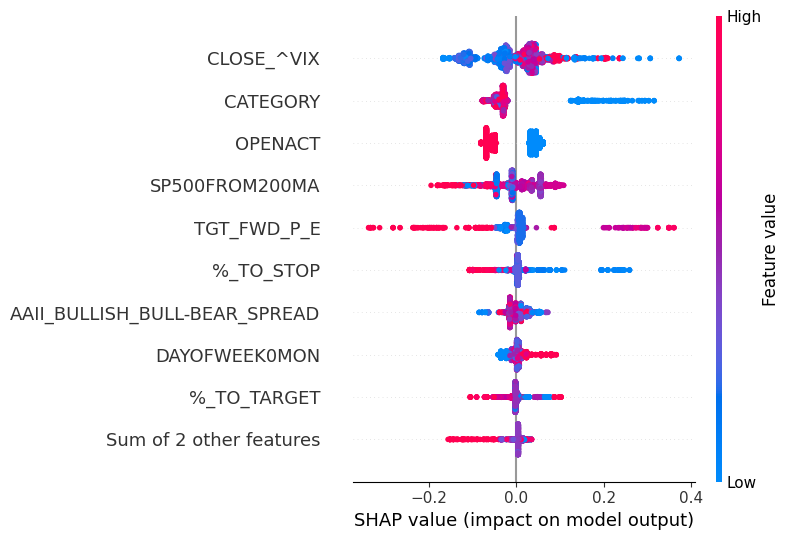

In [14]:
mlflow.end_run()
mlflow.start_run(run_id=runid)

if "pipeline" in str(type(mdl)).lower():
    model_type = "pipeline"

# Create object that can calculate shap values
if model_type == "h2o":
    # print('h2o explanation')
    # h2o_wrapper = H2ORegWrapper(mdl,X.columns)
    # explainer = shap.SamplingExplainer(h2o_wrapper.predict,h2o.H2OFrame(X[0:100]))

    # TODO use lightgbm with astype('category') to create train model
    explainer = sub_gbm(X, y_pred)
elif model_type == "pipeline":
    explainer = shap.Explainer(mdl[-1])
else:
    # assume sklearn etc.
    explainer = shap.Explainer(mdl)

# save expected value
if len(explainer.expected_value.shape) > 0:
    ev = explainer.expected_value[0]
    explainer.expected_value = ev

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
# TODO get rid of sample below
if model_type == "pipeline":
    shap_values = explainer(mdl[0].transform(X))
else:
    shap_values = explainer(X)  # gets full shap_value descriptions

# ensure slicing by column names work
shap_values.feature_names = list(X.columns)

# Make plot. Index of [1] is explained in text below.
# shap.summary_plot(shap_values, X_train)

f = plt.gcf()

# Make plot to save
# shap.summary_plot(shap_values, X,show=False,) # not as informative as beeswarm

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H%M%S")
print("date and time =", dt_string)

if model_type == "pipeline":
    categorical_names = list(X.select_dtypes(include=["object"]).columns)
    col_idx = list(np.where(np.isin(shap_values.feature_names, categorical_names))[0])

    shap_cat = copy.deepcopy(shap_values)
    shap_cat.data = np.array(shap_values.data, dtype="object")
    res_arr = (
        mdl[0]
        .transformers_[1][1][1]
        .inverse_transform(
            pd.DataFrame(shap_cat.data[:, col_idx], columns=[categorical_names])
        )
    )
    for i, loc in enumerate(col_idx):
        shap_cat.data[:, loc] = res_arr[:, i]

shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.savefig(f"summary_plot_{dt_string}.png", bbox_inches="tight")
plt.show()

mlflow.log_metric("expected_val", ev)
mlflow.log_artifact(f"summary_plot_{dt_string}.png")

os.remove(f"summary_plot_{dt_string}.png")

mlflow.end_run()

In [15]:
## save explainer

mlflow.end_run()
mlflow.start_run(run_id=runid)

with open(f"explainer.pkl", "wb") as handle:
    dill.dump(explainer, handle, recurse=True)

mlflow.log_artifact(f"explainer.pkl")

os.remove(f"explainer.pkl")

mlflow.end_run()

In [16]:
## check highest

top_trades = XY_df[XY_df["PCT_RET_FINAL"] > 1]
top_trades.head()

,Unnamed: 0,%_TO_STOP,%_TO_TARGET,AAII_0_LEVEL_0_REPORTED_DATE,AAII_1_LEVEL_0_REPORTED_BULLISH,AAII_2_LEVEL_0_REPORTED_NEUTRAL,AAII_3_LEVEL_0_REPORTED_BEARISH,AAII_4_LEVEL_0_REPORTED_TOTAL,AAII_BULLISH_8-WEEK_MOV_AVG,AAII_BULLISH_AVERAGE_+ST._DEV.,AAII_BULLISH_AVERAGE_-_ST._DEV.,AAII_BULLISH_BULL-BEAR_SPREAD,AAII_BULLISH_BULLISH_AVERAGE,AAII_DATE,AAII_S&P_500_WEEKLY_CLOSE,AAII_S&P_500_WEEKLY_HIGH,AAII_S&P_500_WEEKLY_LOW,ACTION,AGE,AT_PRICE,CASH_CHG_(PNL),CATEGORY,CLOSEACT,CLOSE_DATE,CLOSE_PRICE,CLOSE_^GSPC,CLOSE_^GSPC_200MA,CLOSE_^VIX,COMMENTS,COMMENTS.1,COMMISSION,COMM_TOT,COMPANY_NAME_(IN_ALPHABETICAL_ORDER),CURRENT_PRICE,DATE,DATE_YAHOOFINANCE,DAYOFWEEK0MON,DAYSTOFYEND,EPS1,EPS2,FILENAME,FYEND,FYEPSNXT,GROWTH_0.5TO0.75,LASTUPDATED,OPENACT,OPEN_DATE,OPEN_PRICE,OPEN_YEAR,PCTRETURN,PCT_RET_FINAL,PNL,PRICE,QTYCHG,QUANTITY,ROIC_(BW_ROA_ROE),SP500FROM200MA,STARTDATE,STOP,SYMBOL,TARGET,TGT_FWD_P_E,TICKER,TIME,UNNAMED:_0,UNNAMED:_0.1,UNNAMED:_0.2,UNNAMED:_6,UNNAMED:_8,WEIGHT,YEARS_TO_NORMALIZATION,weight
5,5,-0.1085,-0.0722,2015-06-25 00:00:00,0.355556,0.427778,0.216667,1.000001,0.267944,0.476796,0.275354,0.138889,0.376075,2015-06-25,2108.580000,2129.870000,2082.100000,BOT,10,_NA_,"($7,781.40)",Value,S,2024-12-09 09:55:22,1752.4450,2063.110107,2053.895403,18.23,_NA_,_NA_,1.00,-1.489320,_NA_,_NA_,2015-05-14,2015-06-30,3,_NA_,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,0.1,_NA_,B,2015-06-30 00:00:00,579.659697,2015,_NA_,2.022982,11726.41,778.040,10,10,0.12,0.004486,_NA_,_NA_,MKL,_NA_,20.745,_NA_,9:37:15 AM,2594,59,5,USD,_NA_,0.107374,6,1
79,79,-0.1085,-0.0722,2015-06-25 00:00:00,0.355556,0.427778,0.216667,1.000001,0.267944,0.476796,0.275354,0.138889,0.376075,2015-06-25,2108.580000,2129.870000,2082.100000,BOT,10,_NA_,"($7,781.40)",Value,S,2021-06-17 12:40:33,1184.7050,2063.110107,2053.895403,18.23,_NA_,_NA_,1.00,-1.030805,_NA_,_NA_,2015-05-14,2015-06-30,3,_NA_,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,0.1,_NA_,B,2015-06-30 00:00:00,579.659697,2015,_NA_,1.043447,3024.22,778.040,10,5,0.12,0.004486,_NA_,_NA_,MKL,_NA_,20.745,_NA_,9:37:15 AM,1914,30,79,USD,_NA_,0.107374,6,1
81,81,-0.1085,-0.0722,2015-06-25 00:00:00,0.355556,0.427778,0.216667,1.000001,0.267944,0.476796,0.275354,0.138889,0.376075,2015-06-25,2108.580000,2129.870000,2082.100000,BOT,10,_NA_,"($7,781.40)",Value,S,2024-12-02 10:01:59,1758.5175,2063.110107,2053.895403,18.23,_NA_,_NA_,1.00,-1.491008,_NA_,_NA_,2015-05-14,2015-06-30,3,_NA_,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,0.1,_NA_,B,2015-06-30 00:00:00,579.659697,2015,_NA_,2.033453,11787.11,778.040,10,10,0.12,0.004486,_NA_,_NA_,MKL,_NA_,20.745,_NA_,9:37:15 AM,2592,31,81,USD,_NA_,0.107374,6,1
610,610,-0.1085,-0.0722,2016-04-07 00:00:00,0.321918,0.463470,0.214612,1.000000,0.314051,0.476796,0.275354,0.107306,0.376075,2016-04-07,2066.659912,2075.070068,2042.560059,BOT,9,_NA_,"($6,002.40)",LGrowth,S,2018-09-10 15:53:07,1937.0100,2061.719971,2013.898400,14.85,_NA_,_NA_,1.00,-2.379502,_NA_,_NA_,2016-04-12,2016-04-12,1,_NA_,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,0.1,_NA_,B,2016-04-12 13:04:47,600.140000,2016,_NA_,2.227137,6682.97,600.140,10,5,0.12,0.023746,_NA_,_NA_,AMZN,_NA_,20.745,_NA_,13:04:47,958,610,610,USD,U1060261,0.134218,6,1
706,706,-0.1085,-0.0722,2016-05-12 00:00:00,0.204082,0.482993,0.312925,1.000000,0.280639,0.476796,0.275354,-0.108843,0.376075,2016-05-12,2064.459961,2084.870117,2039.449951,SLD,9,_NA_,"$36,126.81",Value,S,2018-10-03 14:56:30,232.3027,2064.110107,2012.624700,14.41,_NA_,_NA_,2.39,-2.878473,_NA_,_NA_,2016-05-12,2016-05-12,3,_NA_,_NA_,_NA_,PCM-Tracking - LogHist.csv,_NA_,_NA_,0.1,_NA_,B,2016-05-12 11:47:57,90.209450,2016,_NA_,1.574633,3551.17,90.323,400,25,0.12,0.025581,_NA_,_NA_,AAPL,_NA_,20.745,_NA_,10:45:03,979,706,706,USD,U1060261,0.134218,6,1


## plot partial dependence for vars

date and time = 20251026_140547


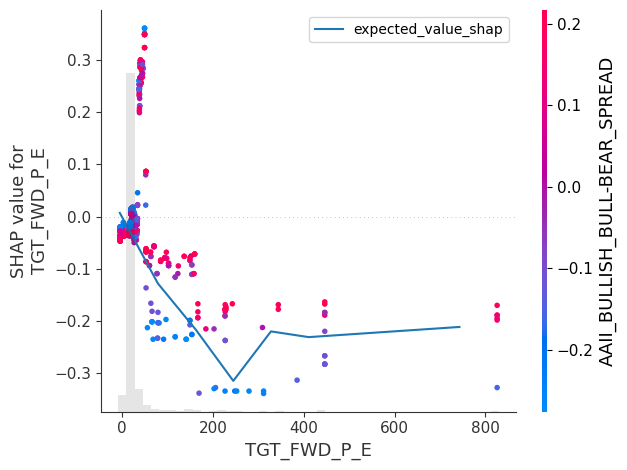

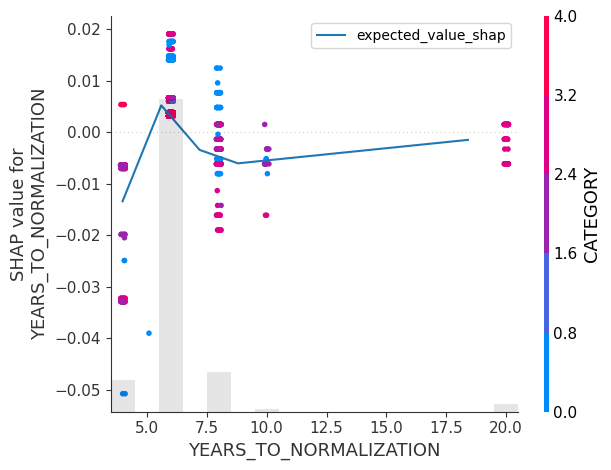

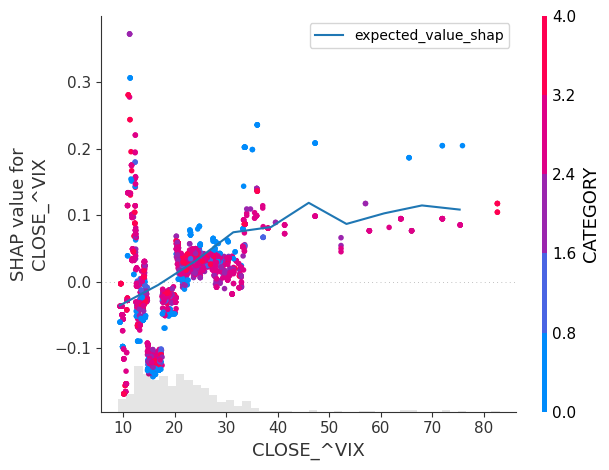

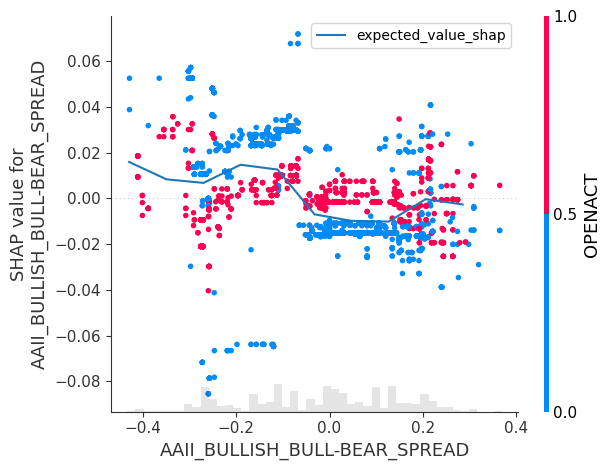

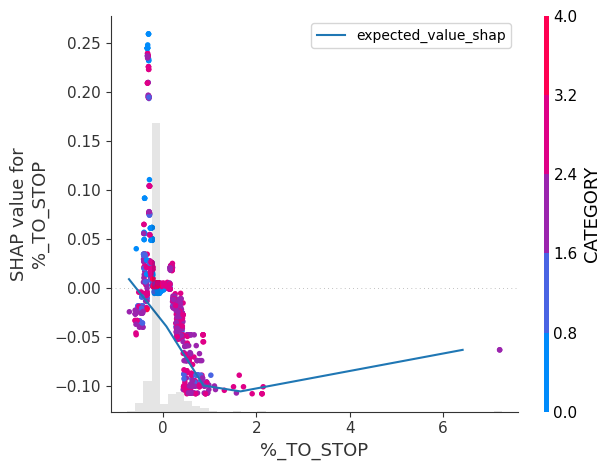

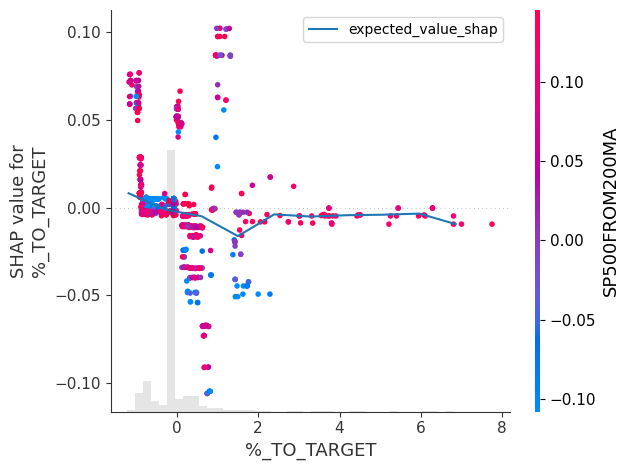

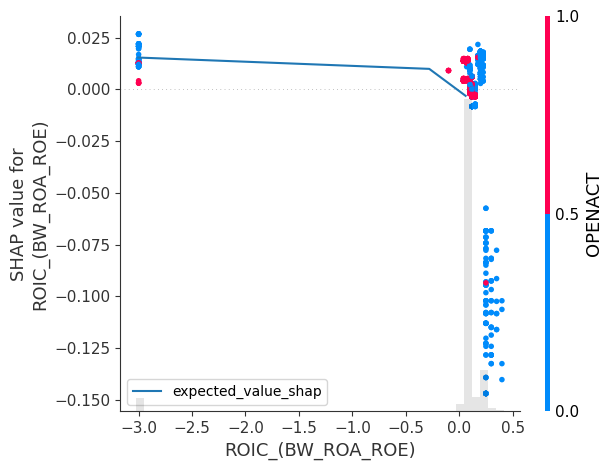

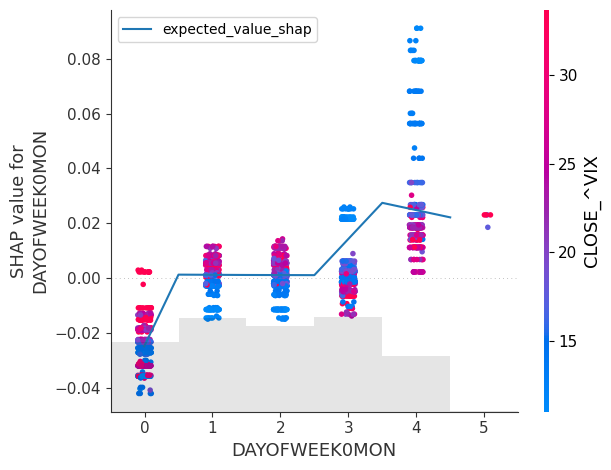

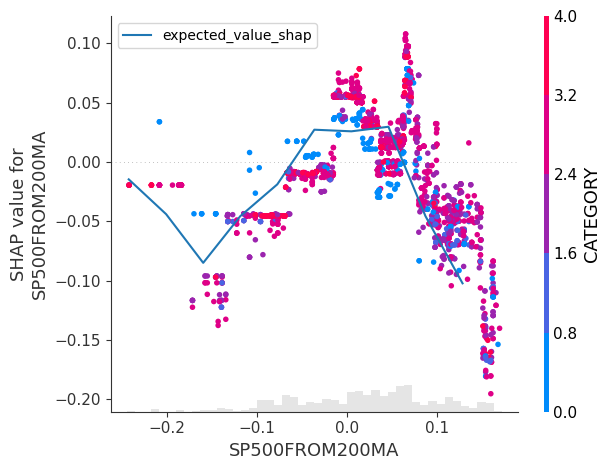

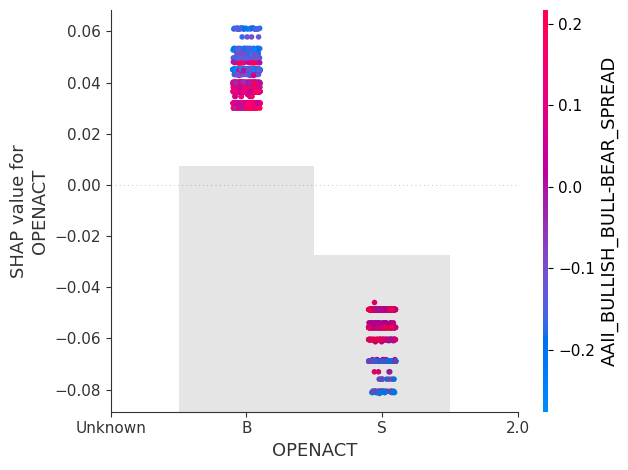

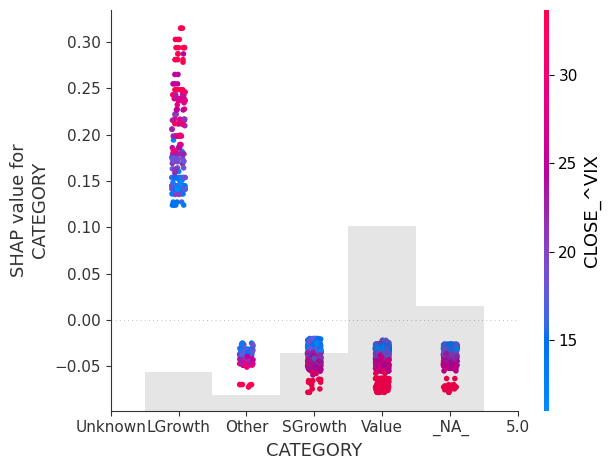

In [17]:
# make plots

mlflow.end_run()
mlflow.start_run(run_id=runid)

# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
print("date and time =", dt_string)

for var in cols_required:
    fig, ax = plt.subplots()

    shap_slice = shap_values[:, var]

    try:
        shap.plots.scatter(shap_slice, ax=ax, show=False, color=shap_values)
    except:
        shap.plots.scatter(shap_slice, ax=ax, show=False)

    if var in categorical_names:
        # get integer labels
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        orig_list = ax.get_xticks()
        new_list = np.insert(
            mdl[0].transformers_[1][1][1].categories_[categorical_names.index(var)],
            0,
            "Unknown",
        )

        for i in range(len(orig_list) - len(new_list)):
            try:
                new_list = np.append(new_list, orig_list[i + len(new_list)])
            except:
                pass

        ax.set_xticks(orig_list)
        ax.set_xticklabels(new_list)

    else:
        # deprecated
        # shap.dependence_plot(var, shap_values.values, X, ax=ax, show=False)

        int_labels, col_bins = pd.cut(X[var], bins=10, retbins=True, labels=False)

        shap_col_df = pd.DataFrame(
            {
                var: col_bins[int_labels],
                "expected_value_shap": shap_values.values[:, X.columns.get_loc(var)],
            }
        )

        shap_col_grp_df = shap_col_df.groupby(var).mean()

        shap_col_grp_df.plot(ax=ax)

    # TODO add
    # shap.plots.partial_dependence(var, mdl.predict, X,  model_expected_value=True)
    # f = plt.gcf()

    plt.tight_layout()
    plt.savefig(f"shappdp_{var}_{dt_string}.png", bbox_inches="tight")
    plt.show()

    mlflow.log_artifact(f"shappdp_{var}_{dt_string}.png")

    os.remove(f"shappdp_{var}_{dt_string}.png")

mlflow.end_run()

In [18]:
## test waterfallplot

main_file = importlib.import_module("P1-AnalyzeTrades_h_predictresult")

res = main_file.predict_return(
    mlflow_tracking_uri="mlruns",  # assumes development
    experiment_name=experiment_name,
    run_id=runid,
    inputs=X.loc[[0], :],
    explain=True,
    show_plot=True,
    preloaded_model=mdl,
)
res

warning, adjusting shap to match actual


C:\Users\Stanley\.virtualenvs\P1-AnalyzeTrades-FUwO02Mg\lib\site-packages\shap\plots\_waterfall.py:371: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Stanley\Documents\StuffDocs\Git\quant-trading\P1-AnalyzeTrades\P1-AnalyzeTrades_h_predictresult.py:343: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


(   predicted_ret
 0       0.120344,
 .values =
 array([[ 0.00858792,  0.00485605, -0.02309281, -0.0140634 ,  0.00391753,
         -0.00141025,  0.00145122,  0.00218727,  0.05605478,  0.03299016,
         -0.02957161]])
 
 .base_values =
 array([0.07843699])
 
 .data =
 array([[ 2.07450000e+01,  6.00000000e+00,  1.82299995e+01,
          1.38889000e-01, -1.08500000e-01, -7.22000000e-02,
          1.20000000e-01,  1.00000000e+00,  4.48645271e-03,
          0.00000000e+00,  4.00000000e+00]]),
    TGT_FWD_P_E  YEARS_TO_NORMALIZATION  CLOSE_^VIX  \
 0     0.008588                0.004856   -0.023093   
 
    AAII_BULLISH_BULL-BEAR_SPREAD  %_TO_STOP  %_TO_TARGET  ROIC_(BW_ROA_ROE)  \
 0                      -0.014063   0.003918     -0.00141           0.001451   
 
    DAYOFWEEK0MON  SP500FROM200MA  OPENACT  CATEGORY  
 0       0.002187        0.056055  0.03299 -0.029572  ,
 <Figure size 800x650 with 3 Axes>)

In [19]:
res

(   predicted_ret
 0       0.120344,
 .values =
 array([[ 0.00858792,  0.00485605, -0.02309281, -0.0140634 ,  0.00391753,
         -0.00141025,  0.00145122,  0.00218727,  0.05605478,  0.03299016,
         -0.02957161]])
 
 .base_values =
 array([0.07843699])
 
 .data =
 array([[ 2.07450000e+01,  6.00000000e+00,  1.82299995e+01,
          1.38889000e-01, -1.08500000e-01, -7.22000000e-02,
          1.20000000e-01,  1.00000000e+00,  4.48645271e-03,
          0.00000000e+00,  4.00000000e+00]]),
    TGT_FWD_P_E  YEARS_TO_NORMALIZATION  CLOSE_^VIX  \
 0     0.008588                0.004856   -0.023093   
 
    AAII_BULLISH_BULL-BEAR_SPREAD  %_TO_STOP  %_TO_TARGET  ROIC_(BW_ROA_ROE)  \
 0                      -0.014063   0.003918     -0.00141           0.001451   
 
    DAYOFWEEK0MON  SP500FROM200MA  OPENACT  CATEGORY  
 0       0.002187        0.056055  0.03299 -0.029572  ,
 <Figure size 800x650 with 3 Axes>)

In [20]:
res[1]

.values =
array([[ 0.00858792,  0.00485605, -0.02309281, -0.0140634 ,  0.00391753,
        -0.00141025,  0.00145122,  0.00218727,  0.05605478,  0.03299016,
        -0.02957161]])

.base_values =
array([0.07843699])

.data =
array([[ 2.07450000e+01,  6.00000000e+00,  1.82299995e+01,
         1.38889000e-01, -1.08500000e-01, -7.22000000e-02,
         1.20000000e-01,  1.00000000e+00,  4.48645271e-03,
         0.00000000e+00,  4.00000000e+00]])

In [21]:
## end mlflow and h2o

mlflow.end_run()
try:
    h2o.cluster().shutdown(prompt=False)  # if want to end earlier
except:
    pass

In [22]:
## backup functions

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html
# def gini(actual, pred, sample_weight = None):
#     #ignores weights
#     assert (len(actual) == len(pred))
#     allv = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
#     allv = allv[np.lexsort((allv[:, 2], -1 * allv[:, 1]))]
#     totalLosses = allv[:, 0].sum()
#     giniSum = allv[:, 0].cumsum().sum() / totalLosses

#     giniSum -= (len(actual) + 1) / 2.
#     return giniSum / len(actual)

# def gini_normalized(truth, predictions, sample_weight=None):
#     return gini(truth, predictions) / gini(truth, truth)

# https://stackoverflow.com/questions/48999542/more-efficient-weighted-gini-coefficient-in-python
# def gini(x, sample_weight=None):
#     # The rest of the code requires numpy arrays.
#     x = np.asarray(x)
#     if sample_weight is not None:
#         w = np.asarray(sample_weight)
#         sorted_indices = np.argsort(x)
#         sorted_x = x[sorted_indices]
#         sorted_w = w[sorted_indices]
#         # Force float dtype to avoid overflows
#         cumw = np.cumsum(sorted_w, dtype=float)
#         cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
#         return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) /
#                 (cumxw[-1] * cumw[-1]))
#     else:
#         sorted_x = np.sort(x)
#         n = len(x)
#         cumx = np.cumsum(sorted_x, dtype=float)
#         # The above formula, with all weights equal to 1 simplifies to:
#         return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# def gini_normalized(y_actual, y_pred, sample_weight=None):
#     """
#     Gini coefficient based on two lists and optional weight list, all of same shape
#     """
#     ans = (gini(y_pred , sample_weight=sample_weight)
#            / gini(y_actual , sample_weight=sample_weight)
#     )
#     return ans